## Recall@K / Precision@K / F1@K / Specificity@K для ранжирования

Мы рассматриваем задачу поиска: по запросу пользователя система выдаёт список изображений
(например, топ-20). Модель присваивает каждому изображению **скор релевантности**.

Для оффлайн-оценки качества мы используем исторические логи:
какие изображения пользователь **кликнул** (клик = релевантно, не клик = нерелевантно).

Ключевая идея: пользователи редко уходят дальше первых результатов,
поэтому качество важно именно в **top-K** (например, K=5, 10, 20).


In [1]:
from typing import List, Dict
import pandas as pd
import matplotlib.pyplot as plt

### Формат данных

Для одного запроса у нас есть:
- `scores` — предсказанный скор релевантности (чем выше, тем выше в выдаче)
- `clicked` — бинарная метка (1 если пользователь кликнул изображение, иначе 0)

Дальше мы сортируем изображения по `scores`, берём top-K и считаем метрики.


In [2]:
df = pd.DataFrame({
    "query_id": [101]*12,
    "image_id": list(range(1, 13)),
    # История кликов (target): 1 = кликнул, 0 = не кликнул
    "clicked": [0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1],
    # Скор новой модели (чем больше, тем выше в выдаче)
    "score":   [0.12, 0.82, 0.33, 0.27, 0.74, 0.10, 0.05, 0.66, 0.21, 0.18, 0.09, 0.58],
})

### Метрики @K

Обозначим:
- TP — кликнутые изображения внутри top-K
- FP — некликнутые изображения внутри top-K
- FN — кликнутые изображения вне top-K
- TN — некликнутые изображения вне top-K

Тогда:
- **Recall@K** = TP / (TP + FN) — какую долю всех кликов мы "поймали" в top-K
- **Precision@K** = TP / (TP + FP) — какая доля top-K действительно была кликнута
- **F1@K** — баланс между precision и recall
- **Specificity@K** = TN / (TN + FP) — как хорошо мы НЕ показываем некликнутые (вне top-K)


In [3]:
def ranking_metrics_at_k(df: pd.DataFrame, k: int) -> Dict[str, float]:
    df_sorted = df.sort_values("score", ascending=False).reset_index(drop=True)

    n = len(df_sorted)
    k = min(k, n)

    top_k = df_sorted.iloc[:k]
    rest = df_sorted.iloc[k:]

    tp = int((top_k["clicked"] == 1).sum())
    fp = int((top_k["clicked"] == 0).sum())
    fn = int((rest["clicked"] == 1).sum())
    tn = int((rest["clicked"] == 0).sum())

    recall = tp / (tp + fn) if (tp + fn) > 0 else 0.0
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0.0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0.0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0.0

    return {
        "k": k,
        "tp": tp, "fp": fp, "fn": fn, "tn": tn,
        "recall@k": recall,
        "precision@k": precision,
        "f1@k": f1,
        "specificity@k": specificity,
    }

### Зависимость метрик от K

Ниже показаны значения метрик при разных K для одного запроса.

В данном примере релевантность бинарная (`clicked ∈ {0, 1}`):
- `clicked = 1` — пользователь кликнул изображение (релевантно)
- `clicked = 0` — не кликнул (нерелевантно)

Метрики считаются по top-K изображений, отсортированных по `score`.


In [4]:
df.sort_values("score", ascending=False).head(5)

,query_id,image_id,clicked,score
1,101,2,1,0.82
4,101,5,1,0.74
7,101,8,1,0.66
11,101,12,1,0.58
2,101,3,0,0.33


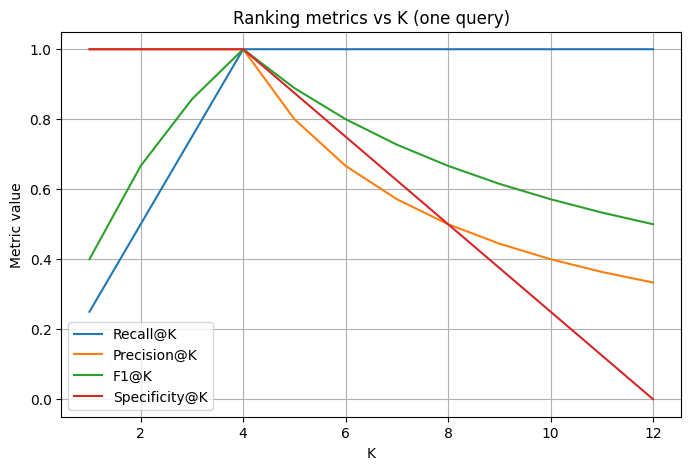

In [5]:
ks = range(1, len(df) + 1)
recalls, precisions, f1s, specs = [], [], [], []

for k in ks:
    m = ranking_metrics_at_k(df, k)
    recalls.append(m["recall@k"])
    precisions.append(m["precision@k"])
    f1s.append(m["f1@k"])
    specs.append(m["specificity@k"])

plt.figure(figsize=(8, 5))
plt.plot(list(ks), recalls, label="Recall@K")
plt.plot(list(ks), precisions, label="Precision@K")
plt.plot(list(ks), f1s, label="F1@K")
plt.plot(list(ks), specs, label="Specificity@K")
plt.xlabel("K")
plt.ylabel("Metric value")
plt.title("Ranking metrics vs K (one query)")
plt.grid(True)
plt.legend()
plt.show()

## Выводы

- Метрики `@K` оценивают качество ранжирования там, где это важно пользователю: в верхней части выдачи (top-K).
- `Recall@K` показывает, какую долю всех кликнутых изображений мы смогли “поймать” в top-K.
  При увеличении K `Recall@K` не убывает, потому что в выдачу попадает больше объектов.
- `Precision@K` показывает, какая доля изображений в top-K действительно была кликнута.
  При увеличении K, precision часто падает, так как в топ начинают попадать менее релевантные элементы.
- `F1@K` помогает оценить компромисс между `precision@K` и `recall@K` при фиксированном K.
- `Specificity@K` отражает, насколько хорошо система “удерживает” некликнутые изображения вне top-K.

Практический вывод: сравнивать модели корректно только при фиксированном K (например, K=10 или K=20),
который выбирается исходя из продуктовых требований к выдаче.
